In [122]:
import tifffile as tiff
import os
from glob import glob
from tensorflow.keras.utils import img_to_array, load_img
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize

In [284]:
train_folder = 'train'
images = []
masks = []

for patient_folder in os.listdir(train_folder):
    img_path = os.path.join(train_folder, patient_folder, 'images')
    mask_path = os.path.join(train_folder, patient_folder, 'masks')

    image_file = glob(os.path.join(img_path, '*.[jp][pn]g'))[0]
    image = load_img(image_file, target_size=(256, 256), color_mode='grayscale')

    image = img_to_array(image) / 255.0
    
    mask_files = glob(os.path.join(mask_path, '*.tiff'))
    mask_combined = np.zeros((256, 256), dtype=np.uint8)

    for mask_file in mask_files:
        mask = tiff.imread(mask_file)
        mask = resize(mask, (256, 256), anti_aliasing=True)
        mask = mask / 255.0
        mask_combined = np.maximum(mask_combined, mask)

    images.append(image)
    masks.append(mask_combined)

In [285]:
x_train, y_train = np.array(images), np.array(masks)

In [286]:
import tensorflow as tf
from keras import layers, models

#foundation model --research more later
def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)
    
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 256, 256,  │        640 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_94[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 128, 128,  │          0 │ conv2d_95[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_17… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_96[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 64, 64,    │          0 │ conv2d_97[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_18… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_98[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_17 │ (None, 128, 128,  │    131,200 │ conv2d_99[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_97[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 128, 128,  │    295,040 │ concatenate_16[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 128, 128,  │    147,584 │ conv2d_100[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_18 │ (None, 256, 256,  │     32,832 │ conv2d_101[0][0]  │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_95[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 256, 256,  │     73,792 │ concatenate_17[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 256, 256,  │     36,928 │ conv2d_102[0][0]

 Total params: 1,861,697 (7.10 MB)

 Trainable params: 1,861,697 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

In [287]:
history = model.fit(x_train, y_train, epochs=5, batch_size=2)

Epoch 1/5


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 995ms/step - accuracy: 0.6477 - loss: 0.3832
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 942ms/step - accuracy: 0.8721 - loss: 1.1921e-07
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 975ms/step - accuracy: 0.8862 - loss: 1.1921e-07
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 943ms/step - accuracy: 0.8863 - loss: 1.1921e-07
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 946ms/step - accuracy: 0.8860 - loss: 1.1921e-07


In [205]:
image = load_img('train/DigX_01012009_120804/images/DigX_01012009_120804.jpg', target_size=(256, 256), color_mode='grayscale')
image = img_to_array(image) / 255.0
image = np.expand_dims(x_train[1], axis=0) 

In [206]:
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


In [212]:
len(x_train[0])

256

In [213]:
predicted_mask = (prediction > 0.5).astype(np.uint8)

In [214]:
predicted_mask = np.squeeze(predicted_mask)


In [313]:
test_image = load_img('image labelling inprocess/DigX_01022009_144408.jpg', target_size=(256, 256), color_mode='grayscale')
test_image = img_to_array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis=0)

In [314]:
pred = model.predict(test_image)[0]
pred = (pred > 0).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


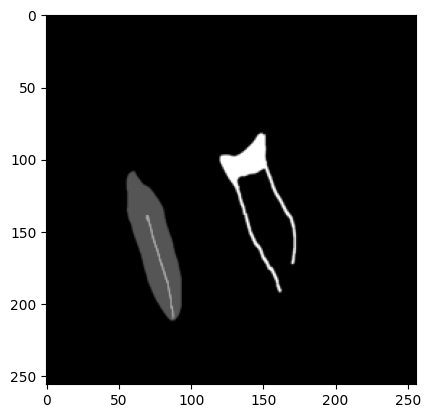

In [305]:
plt.imshow(masks[7], cmap='gray')

In [322]:
test_image = x_test[10]
test_output = masks[10]

In [323]:
test_output = (test_output > 0).astype(np.uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


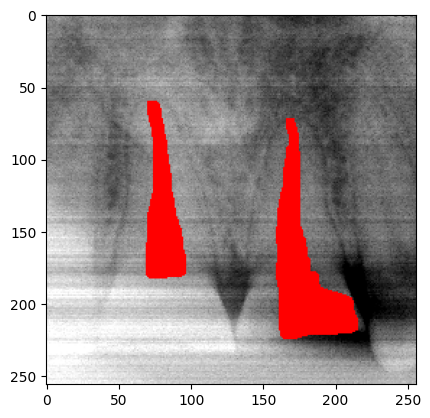

In [324]:

test_output = np.squeeze(test_output) 
test_image = np.squeeze(test_image)   

test_image_rgb = np.stack((test_image,) * 3, axis=-1)

rgb_mask = np.zeros_like(test_image_rgb) 
rgb_mask[:, :, 0] = test_output * 255 

overlay = test_image_rgb.copy()
overlay[test_output == 1] = rgb_mask[test_output == 1]


plt.imshow(overlay)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.0..255.0].


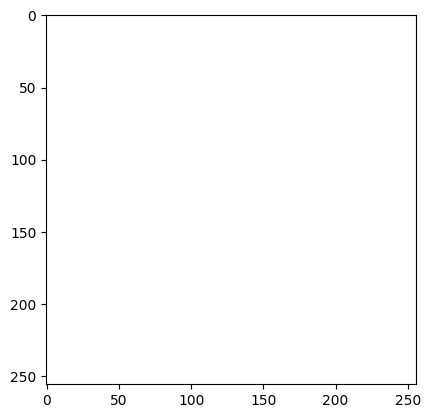

In [262]:
plt.imshow(overlay, cmap='gray')

In [267]:
max(test_output[100])

0.027024565503705418